# Quality Controlling Saildrone T/S

## Objective:

This notebook shows how to use CoTeDe to evaluate temperature and salinity measured along-track from a Saildrone.

The nature of this dataset is similar to a Thermosalinograph (TSG) on vessels of opportunity. As the vessel sails, it pumps water from near the surface, which is measured by a CTD. Thus, it is a time-series with a nearly constant depth, and each measurement is associated with time, latitude, and longitude.

## Data:

For this tutorial, let's use the Saildrone Antarctic Cirumnaviation mission (https://www.saildrone.com/antarctica). I don't want to bypass their data distribution, so I'll let you download it yourself. Please place it in the same directory (folder) of this notebook.

Let's use the 24hrs resolution just for demonstration purposes since this is the public version. We will probably get better results by quality controlling on the high-resolution measurements and only then, if convenient for our scientific questions, sub-sample for lower resolution.

The data is available at https://data.saildrone.com/data/sets/antarctica-circumnavigation-2019/access

Let's import xarray, which we'll use to load the data from the netCDF. We could use netCDF4 or scipy, but it is probably more intuitive with xarray.

Let's also import ProfileQC from CoTeDe. Yes, I know, Saildrone does not measure profiles but don't worry about the name of this class; it will work with the same principle. Maybe one day, I'll create another class to deal with the along-track type of measurements.

In [1]:
import xarray as xr
from cotede import ProfileQC

### First, learn about the data

Load the data

In [2]:
ds = xr.open_dataset('saildrone-antarctica.nc')

Let's learn about this dataset, starting from the attributes.

In [3]:
ds.attrs['Conventions']

'CF-1.6, ACDD-1.3'

Great, it follows the CF and ACDD conventions, so we don't need to wander around, but we know what to expect and where to find the information that we will need. For instance, does it conform with some Simple Geometry? If so, which one?

In [4]:
ds.attrs['featureType']

'trajectory'

OK, this is a trajectory, so we expect that each measurement will have a time and position.

What are the available variables? We are interested in the temperature and the salinity of the seawater.

In [5]:
list(ds.keys())

['SOG',
 'COG',
 'HDG',
 'HDG_WING',
 'ROLL',
 'PITCH',
 'WING_ANGLE',
 'BARO_PRES_MEAN',
 'BARO_PRES_STDDEV',
 'TEMP_AIR_MEAN',
 'TEMP_AIR_STDDEV',
 'RH_MEAN',
 'RH_STDDEV',
 'PAR_AIR_MEAN',
 'PAR_AIR_STDDEV',
 'TEMP_IR_UNCOR_MEAN',
 'TEMP_IR_UNCOR_STDDEV',
 'UWND_MEAN',
 'UWND_STDDEV',
 'VWND_MEAN',
 'VWND_STDDEV',
 'WWND_MEAN',
 'WWND_STDDEV',
 'GUST_WND_MEAN',
 'GUST_WND_STDDEV',
 'TEMP_CTD_MEAN',
 'TEMP_CTD_STDDEV',
 'COND_MEAN',
 'COND_STDDEV',
 'SAL_MEAN',
 'SAL_STDDEV',
 'O2_RBR_CONC_MEAN',
 'O2_RBR_CONC_STDDEV',
 'O2_RBR_SAT_MEAN',
 'O2_RBR_SAT_STDDEV',
 'TEMP_O2_RBR_MEAN',
 'TEMP_O2_RBR_STDDEV',
 'O2_AANDERAA_CONC_UNCOR_MEAN',
 'O2_AANDERAA_CONC_UNCOR_STDDEV',
 'O2_AANDERAA_SAT_MEAN',
 'O2_AANDERAA_SAT_STDDEV',
 'TEMP_O2_AANDERAA_MEAN',
 'TEMP_O2_AANDERAA_STDDEV',
 'CHLOR_MEAN',
 'CHLOR_STDDEV']

It looks like we are interested in TEMP_CTD_MEAN and SAL_MEAN. Let's confirm that. We can learn a lot by inspecting the Attributes.

In [6]:
print(ds["SAL_MEAN"])
print("====")
print(ds["TEMP_CTD_MEAN"])

<xarray.DataArray 'SAL_MEAN' (trajectory: 1, obs: 248525)>
[248525 values with dtype=float64]
Coordinates:
  * trajectory  (trajectory) float32 1020.0
    time        (trajectory, obs) datetime64[ns] ...
    latitude    (trajectory, obs) float64 ...
    longitude   (trajectory, obs) float64 ...
Dimensions without coordinates: obs
Attributes:
    standard_name:              sea_water_practical_salinity
    long_name:                  Seawater salinity
    units:                      1
    last_calibrated:            2018-10-19
    update_period:              500
    device_name:                RBR CTD/ODO/Chl-A (40804)
    installed_date:             2018-11-01T00:00:00Z
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    installed_height:           -0.53
    serial_number:              40804
    vendor_name:                RBR
    model_name:                 Saildrone^3
====
<xarray.DataArray 'TEMP_CTD_MEAN' (trajectory: 1, obs: 248525)>
[248525 values with dtype=float

Yes, we can see in the attributes of both variables the standard_name and long_name. We found what we need. Let's simplify our dataset and extract only what we need - temperature and salinity - and call it "tsg".

In [7]:
tsg = ds[['TEMP_CTD_MEAN', 'SAL_MEAN']]
tsg

<xarray.Dataset>
Dimensions:        (obs: 248525, trajectory: 1)
Coordinates:
    time           (trajectory, obs) datetime64[ns] ...
    longitude      (trajectory, obs) float64 ...
    latitude       (trajectory, obs) float64 ...
  * trajectory     (trajectory) float32 1020.0
Dimensions without coordinates: obs
Data variables:
    TEMP_CTD_MEAN  (trajectory, obs) float64 ...
    SAL_MEAN       (trajectory, obs) float64 ...
Attributes:
    title:                     Antarctica Circumnavigation Surface Data
    license:                   2019 © SAILDRONE Inc.  All Rights Reserved.  T...
    wmo_id:                    4803902
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.4.1.1
    featureType:               trajectory
    cdm_data_type:             Trajectory
    standard_name_vocabulary:  CF Standard Name Table v58
    description:               Saildrone NetCDF Format
    creator_name:              Saildrone
    platform:                  Saildrone
    institution:               Saildrone
    creator_email:             support@saildrone.com
    creator_url:               http://saildrone.com/
    date_created:              2019-08-03T19:10:55.100403Z
    interval:                  60.0
    time_coverage_resolution:  PT1M
    time_coverage_start:       2019-01-19T04:00:00.000000Z
    time_coverage_end:         2019-08-03T04:30:00.000000Z
    time_coverage_duration:    P196DT30M
    area:                      Southern Ocean
    data_mode:                 realtime
    drone_id:                  1020
    id:                        43797
    naming_authority:          com.saildrone
    uuid:                      91c12ae3-3637-4934-bd4e-e00693435f74
    project:                   antarctica_circumnavigation_2019
    geospatial_lat_min:        -60.9862208
    geospatial_lat_max:        -46.4277568
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -179.9986816
    geospatial_lon_max:        179.9997312
    geospatial_lon_units:      degrees_east
    summary:                   This data set was collected from the first Sai...

Notice that there is a trajectory dimension. Since this is a single trajectory, CF does not require to keep this dimension, but this is a good practice. In case we want to merge this dataset with another trajectory, let's say another Saildrone from another year, and both trajectories would merge seamlessly with two trajectories.

To simplify, let's remove the trajectory dimension by choosing only the first (and only one) trajectory.

In [8]:
tsg = tsg.isel(trajectory=0)

Now, if we look at the temperature, it will have only the dimension obs.

In [9]:
tsg['TEMP_CTD_MEAN']

<xarray.DataArray 'TEMP_CTD_MEAN' (obs: 248525)>
[248525 values with dtype=float64]
Coordinates:
    time        (obs) datetime64[ns] ...
    longitude   (obs) float64 ...
    latitude    (obs) float64 ...
    trajectory  float32 1020.0
Dimensions without coordinates: obs
Attributes:
    standard_name:              sea_water_temperature
    long_name:                  Seawater temperature
    units:                      degrees_c
    last_calibrated:            2018-10-19
    update_period:              500
    device_name:                RBR CTD/ODO/Chl-A (40804)
    installed_date:             2018-11-01T00:00:00Z
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    installed_height:           -0.53
    serial_number:              40804
    vendor_name:                RBR
    model_name:                 Saildrone^3

In [10]:
tsg['SAL_MEAN'].attrs

{'standard_name': 'sea_water_practical_salinity',
 'long_name': 'Seawater salinity',
 'units': '1',
 'last_calibrated': '2018-10-19',
 'update_period': 500,
 'device_name': 'RBR CTD/ODO/Chl-A (40804)',
 'installed_date': '2018-11-01T00:00:00Z',
 'nominal_sampling_schedule': '12s on, 48s off, centered at :00',
 'installed_height': -0.53,
 'serial_number': '40804',
 'vendor_name': 'RBR',
 'model_name': 'Saildrone^3'}

In [11]:
tsg['TEMP_CTD_MEAN'][:10]

<xarray.DataArray 'TEMP_CTD_MEAN' (obs: 10)>
array([15.68 , 15.671, 15.683, 15.689, 15.688, 15.697, 15.707, 15.718, 15.726,
       15.73 ])
Coordinates:
    time        (obs) datetime64[ns] ...
    longitude   (obs) float64 ...
    latitude    (obs) float64 ...
    trajectory  float32 1020.0
Dimensions without coordinates: obs
Attributes:
    standard_name:              sea_water_temperature
    long_name:                  Seawater temperature
    units:                      degrees_c
    last_calibrated:            2018-10-19
    update_period:              500
    device_name:                RBR CTD/ODO/Chl-A (40804)
    installed_date:             2018-11-01T00:00:00Z
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    installed_height:           -0.53
    serial_number:              40804
    vendor_name:                RBR
    model_name:                 Saildrone^3

## Actuall QC

So far, we have been learning about this dataset and subsampling. 
If you were familiar with this dataset, you could have skipped all that and started here.

Now, let's QC this data, the easiest part (if using CoTeDe).

In [12]:
pqc = ProfileQC(tsg, {'sea_water_temperature':{'gradient': {'threshold': 5}}})

Great! You just finished to QC the temperature of the whole Saildrone Antarctic mission. It's probably not the best approach to use the gradient test only, but good enough for this example.

What are the flags available?

In [13]:
pqc.flags.keys()

dict_keys(['TEMP_CTD_MEAN'])

Yes, it seems right. We asked to inspect all variables that were the type: seawater temperature.

What was the result, i.e. what are the flags assigned?

In [14]:
pqc.flags['TEMP_CTD_MEAN']['gradient']

array([0, 1, 1, ..., 1, 1, 0], dtype=int8)

Let's improve this. Let's evaluate temperature and salinity at the same time, but now let's add another test, the rate of change.

In [15]:
cfg = {
    'sea_water_temperature':{
        'gradient': {'threshold': 5},
        'rate_of_change': {'threshold': 5}},
    'SAL_MEAN': {
        'rate_of_change': {'threshold': 2}}
}
    
pqc = ProfileQC(tsg, cfg)

In [16]:
pqc.flags

{'TEMP_CTD_MEAN': {'gradient': array([0, 1, 1, ..., 1, 1, 0], dtype=int8),
  'rate_of_change': array([0, 1, 1, ..., 1, 1, 1], dtype=int8),
  'overall': array([0, 1, 1, ..., 1, 1, 1], dtype=int8)},
 'SAL_MEAN': {'rate_of_change': array([0, 1, 1, ..., 1, 1, 1], dtype=int8),
  'overall': array([0, 1, 1, ..., 1, 1, 1], dtype=int8)}}

Nice, you can choose which tests to apply on each variable, and that includes which parameters to use on each test.

You also can choose between defining a test for the type of measurement (sea_water_temperature) or the variable specifically (SAL_MEAN). That is convenient when you have a platform equipped with several sensors, like Saildrone.

Finally, let's check what we got!

Text(0.5, 1.0, 'Temperature [$^\\circ$C]')

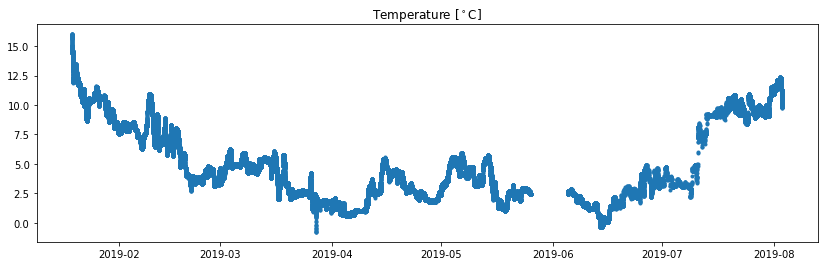

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))

idx = pqc.flags['TEMP_CTD_MEAN']['overall'] <= 2
plt.plot(pqc['time'][idx], pqc['TEMP_CTD_MEAN'][idx], '.')
plt.title('Temperature [$^\circ$C]')


Text(0.5, 1.0, 'Salinity')

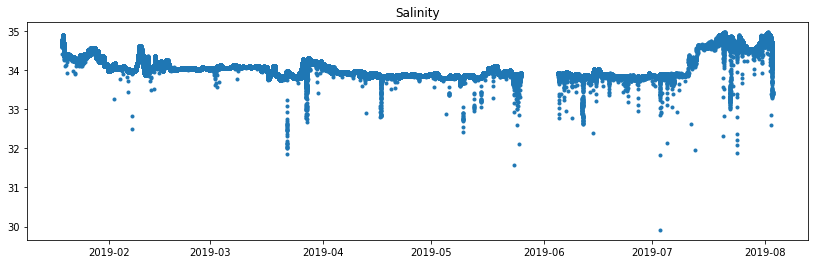

In [18]:
plt.figure(figsize=(14,4))

idx = pqc.flags['SAL_MEAN']['overall'] <= 2
plt.plot(pqc['time'][idx], pqc['SAL_MEAN'][idx], '.')
plt.title('Salinity')

Yes, I agree, we need to activate more checks if we want to do a better job here. Don't worry, there are plenty built-in tests in CoTeDe.